[**Original link here**](https://www.kaggle.com/code/vortexkol/ddsm-breast-cancer-densenet121)

# **Download the dataset from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "shenhav026" # username from the json file
os.environ['KAGGLE_KEY'] = "fecdd1158d18301e53d18c19ed884477" # key from the json file

In [ ]:
! kaggle datasets download -d skooch/ddsm-mammography

100% 2.88G/2.88G [01:34<00:00, 36.9MB/s]
100% 2.88G/2.88G [01:34<00:00, 32.7MB/s]


In [ ]:
! mkdir dataset
! unzip ddsm-mammography.zip -d dataset

Archive:  ddsm-mammography.zip
  inflating: dataset/cv10_data/cv10_data.npy  
  inflating: dataset/cv10_labels.npy  
  inflating: dataset/test10_data/test10_data.npy  
  inflating: dataset/test10_labels.npy  
  inflating: dataset/training10_0/training10_0.tfrecords  
  inflating: dataset/training10_1/training10_1.tfrecords  
  inflating: dataset/training10_2/training10_2.tfrecords  
  inflating: dataset/training10_3/training10_3.tfrecords  
  inflating: dataset/training10_4/training10_4.tfrecords  


# **Reading TFRecord files**

In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()
from sklearn.svm import SVC # SVC
from sklearn import metrics,preprocessing
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras.metrics import AUC
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.applications.densenet import DenseNet121 # DenseNet121
from keras.applications.inception_v3 import InceptionV3 # InceptionV3
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, activations

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }
    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['/content/dataset/training10_0/training10_0.tfrecords',
          '/content/dataset/training10_1/training10_1.tfrecords',
          '/content/dataset/training10_2/training10_2.tfrecords',
          '/content/dataset/training10_3/training10_3.tfrecords',
          '/content/dataset/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

# **Training**

In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)

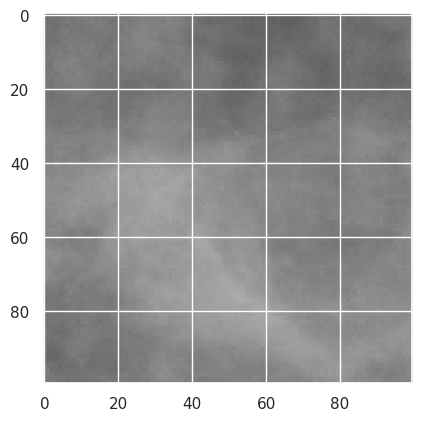

In [ ]:
plt.imshow(x_train[0])

In [ ]:
print(x_train[0].shape)

(100, 100, 3)


In [ ]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

(100, 100, 3)


# **Models**

**DenseNet121 Model**

In [ ]:
def create_densenet121():
  base_model = DenseNet121(input_shape=(100,100,3), weights='imagenet', include_top=False)
  model=Sequential()
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1,activation='sigmoid'))

  for layer in base_model.layers:
      layer.trainable = False

  #model.summary()

  #es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

  device_name = tf.test.gpu_device_name()
  if len(device_name) > 0:
      print("Found GPU at: {}".format(device_name))
  else:
      device_name = "/device:CPU:0"
      print("No GPU, using {}.".format(device_name))

  with tf.device(device_name):
    opt = tf.keras.optimizers.Adam(learning_rate=0.000005)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    #history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=5, batch_size=128,callbacks=[es])
    history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=100, batch_size=64)
    loss_value_test , accuracy_test = model.evaluate(x_test, y_test)
    loss_value_train , accuracy_train = model.evaluate(x_train, y_train)


  Acc_Epochs_Plot(history)

  print('Test_loss_train_value = ' +str(loss_value_train))
  print('test_accuracy_train = ' + str(accuracy_train))

  print('Test_loss_value = ' +str(loss_value_test))
  print('test_accuracy = ' + str(accuracy_test))

  return model

Found GPU at: /device:GPU:0
Epoch 1/100
559/559 [==============================] - 44s 62ms/step - loss: 0.5974 - accuracy: 0.6906 - val_loss: 0.4192 - val_accuracy: 0.8639
Epoch 2/100
559/559 [==============================] - 31s 56ms/step - loss: 0.3965 - accuracy: 0.8435 - val_loss: 0.3221 - val_accuracy: 0.8809
Epoch 3/100
559/559 [==============================] - 31s 55ms/step - loss: 0.3294 - accuracy: 0.8685 - val_loss: 0.2810 - val_accuracy: 0.8917
Epoch 4/100
559/559 [==============================] - 31s 56ms/step - loss: 0.2966 - accuracy: 0.8771 - val_loss: 0.2577 - val_accuracy: 0.8969
Epoch 5/100
559/559 [==============================] - 31s 56ms/step - loss: 0.2785 - accuracy: 0.8841 - val_loss: 0.2478 - val_accuracy: 0.8980
Epoch 6/100
559/559 [==============================] - 32s 57ms/step - loss: 0.2675 - accuracy: 0.8886 - val_loss: 0.2381 - val_accuracy: 0.9001
Epoch 7/100
559/559 [==============================] - 32s 58ms/step - loss: 0.2582 - accuracy: 0.8924

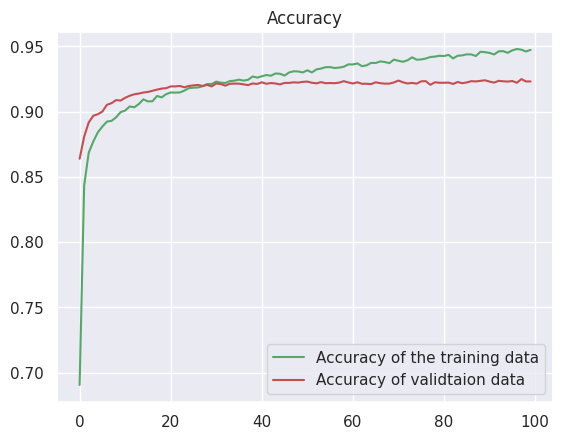

<Figure size 640x480 with 0 Axes>

Test_loss_train_value = 0.11106845736503601
test_accuracy_train = 0.9563388824462891
Test_loss_value = 0.19602960348129272
test_accuracy = 0.9241299033164978


In [ ]:
densenet_121 = create_densenet121()

In [ ]:
densenet_121.save_weights(filepath="/content/drive/MyDrive/Models/densenet121_mom/", overwrite=True, save_format=None, options=None)

**Inception V3 Model**

In [ ]:
def create_inceptionV3():
  base_model = InceptionV3(input_shape=(100,100,3), weights='imagenet', include_top=False)
  model=Sequential()
  model.add(base_model)
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1,activation='sigmoid'))
  for layer in base_model.layers:
      layer.trainable = False

  #model.summary()

  #es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

  device_name = tf.test.gpu_device_name()
  if len(device_name) > 0:
      print("Found GPU at: {}".format(device_name))
  else:
      device_name = "/device:CPU:0"
      print("No GPU, using {}.".format(device_name))

  with tf.device(device_name):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    #history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=25, batch_size=128,callbacks=[es])
    history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=150, batch_size=128)
    loss_value_test , accuracy_test = model.evaluate(x_test, y_test)
    loss_value_train , accuracy_train = model.evaluate(x_train, y_train)

  #Acc_Epochs_Plot(history)
  print('Test_loss_train_value = ' +str(loss_value_train))
  print('test_accuracy_train = ' + str(accuracy_train))

  print('Test_loss_value = ' +str(loss_value_test))
  print('test_accuracy = ' + str(accuracy_test))
  return model

Found GPU at: /device:GPU:0
Epoch 1/150
280/280 [==============================] - 25s 62ms/step - loss: 0.2771 - accuracy: 0.8881 - val_loss: 0.3219 - val_accuracy: 0.8577
Epoch 2/150
280/280 [==============================] - 15s 55ms/step - loss: 0.2408 - accuracy: 0.9002 - val_loss: 0.2310 - val_accuracy: 0.9028
Epoch 3/150
280/280 [==============================] - 16s 55ms/step - loss: 0.2333 - accuracy: 0.9026 - val_loss: 0.2312 - val_accuracy: 0.9027
Epoch 4/150
280/280 [==============================] - 16s 56ms/step - loss: 0.2269 - accuracy: 0.9051 - val_loss: 0.2325 - val_accuracy: 0.9014
Epoch 5/150
280/280 [==============================] - 16s 56ms/step - loss: 0.2241 - accuracy: 0.9050 - val_loss: 0.2284 - val_accuracy: 0.9034
Epoch 6/150
280/280 [==============================] - 16s 56ms/step - loss: 0.2239 - accuracy: 0.9050 - val_loss: 0.2274 - val_accuracy: 0.9045
Epoch 7/150
280/280 [==============================] - 16s 56ms/step - loss: 0.2202 - accuracy: 0.9081

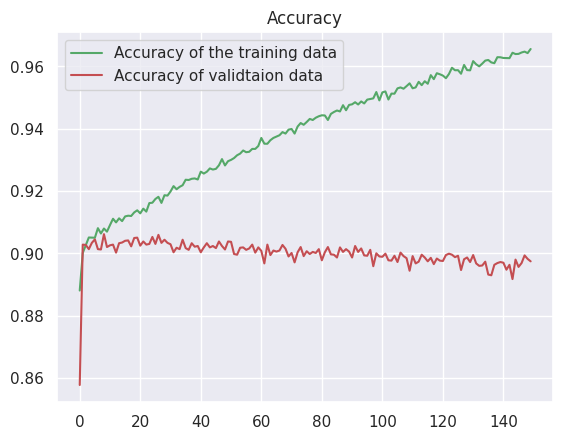

<Figure size 640x480 with 0 Axes>

Test_loss_train_value = 0.11997931450605392
test_accuracy_train = 0.966381847858429
Test_loss_value = 0.4186754524707794
test_accuracy = 0.8957681059837341


In [ ]:
inception_v3 = create_inceptionV3()
#inception_v3.save_weights(filepath="/content/drive/MyDrive/Models/inception_mom/", overwrite=True, save_format=None, options=None)

#**Comparing between the models**

29084464/29084464 [==============================] - 2s 0us/step
Found GPU at: /device:GPU:0
Epoch 1/50
559/559 [==============================] - 55s 66ms/step - loss: 0.7959 - accuracy: 0.5414 - val_loss: 0.5519 - val_accuracy: 0.7932
Epoch 2/50
559/559 [==============================] - 32s 57ms/step - loss: 0.4927 - accuracy: 0.7899 - val_loss: 0.4134 - val_accuracy: 0.8631
Epoch 3/50
559/559 [==============================] - 33s 58ms/step - loss: 0.3734 - accuracy: 0.8550 - val_loss: 0.3374 - val_accuracy: 0.8755
Epoch 4/50
559/559 [==============================] - 32s 58ms/step - loss: 0.3218 - accuracy: 0.8730 - val_loss: 0.2950 - val_accuracy: 0.8822
Epoch 5/50
559/559 [==============================] - 32s 58ms/step - loss: 0.2933 - accuracy: 0.8822 - val_loss: 0.2718 - val_accuracy: 0.8887
Epoch 6/50
559/559 [==============================] - 32s 58ms/step - loss: 0.2796 - accuracy: 0.8842 - val_loss: 0.2562 - val_accuracy: 0.8915
Epoch 7/50
559/559 [=======================

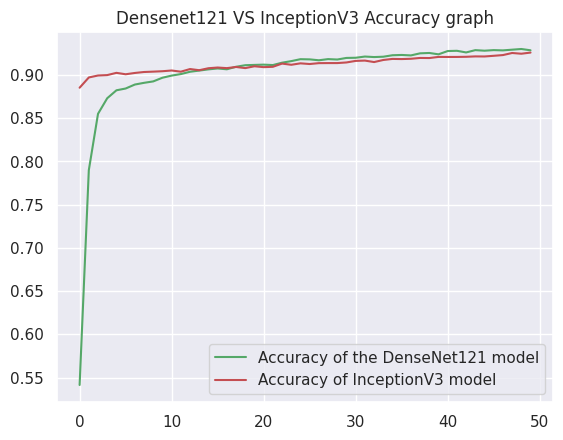

<Figure size 640x480 with 0 Axes>

In [ ]:
base_model = DenseNet121(input_shape=(100,100,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

  #model.summary()

  #es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
    opt = tf.keras.optimizers.Adam(learning_rate=0.000005)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    history1 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)



base_model = InceptionV3(input_shape=(100,100,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
for layer in base_model.layers:
    layer.trainable = False

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    history2 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)

Acc_DenseNet121_VS_Inception_Plot(history1,history2)


# **All below will be used in the main optimaly**

In [ ]:
def predict_densenet_test_data(X_test):
    y_pred = densenet_121.predict(X_test)

    TP1 = 0
    FP1 = 0
    TN1 = 0
    FN1 = 0

    for i in range(len(X_test)):
      if y_test[i]==1 and y_pred[i][1] >= y_pred[i][0]:
        TP1 += 1
      if y_test[i]==0 and y_pred[i][1] > y_pred[i][0]:
        FP1 += 1
      if y_test[i]==0 and y_pred[i][0] >= y_pred[i][1]:
        TN1 += 1
      if y_test[i]==1 and y_pred[i][0] >= y_pred[i][1]:
        FN1 += 1

    print(f"TP = {TP1}, FP = {FP1}, TN = {TN1}, FN = {FN1}")

    if TP1 >0 or (FP1 >0 and FN1>0): #make sure to not divide by zero
      print(f"Accuracy = {(TP1+TN1)/(TP1+FP1+TN1+FN1)}")
      print(f"Precision = {TP1/(TP1+FP1)}")
      print(f"Recall = {TP1/(TP1+FN1)}")

In [ ]:
def Acc_Epochs_Plot(hist):
  get_acc_train = hist.history['accuracy']
  get_acc_val = hist.history['val_accuracy']
  epochs = range(len(get_acc_train))
  plt.plot(epochs, get_acc_train, 'g' , label = 'Accuracy of the training data')
  plt.plot(epochs, get_acc_val, 'r', label = 'Accuracy of validtaion data')
  plt.title('Accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

In [ ]:
def Acc_DenseNet121_VS_Inception_Plot(hist1,hist2):
  get_acc_densnet = hist1.history['accuracy']
  get_acc_inception = hist2.history['accuracy']
  epochs = range(len(get_acc_densnet))
  plt.plot(epochs, get_acc_densnet, 'g' , label = 'Accuracy of the DenseNet121 model')
  plt.plot(epochs, get_acc_inception, 'r', label = 'Accuracy of InceptionV3 model')
  plt.title('Densenet121 VS InceptionV3 Accuracy graph')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

In [ ]:
y_pred_densenet = np.argmax(densenet_121.predict(x_test), axis=1)
#predict_densenet_test_data(np.argmax(densenet_121.predict(x_test)))
densenet_acc = metrics.accuracy_score(y_test, y_pred_densenet)
densenet_acc

350/350 [==============================] - 8s 22ms/step


0.8695535474635412

In [ ]:
y_pred_inception = np.argmax(inception_v3.predict(x_test),axis=1)
inception_acc = metrics.accuracy_score(y_test, y_pred_inception)

350/350 [==============================] - 4s 9ms/step


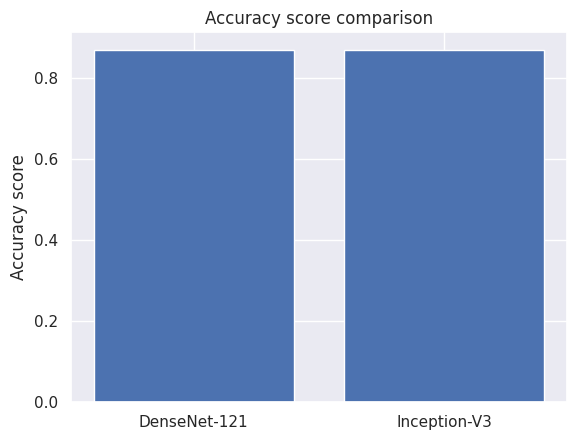

In [ ]:
# comparison between the accuracy scores before and after the adjustment
fig, ax = plt.subplots()
ax.bar(["DenseNet-121", "Inception-V3"], [densenet_acc, inception_acc])
ax.set_title("Accuracy score comparison")
ax.set_ylabel("Accuracy score")
plt.show()